# Heat & Salinity Budgets — NEMO GYRE

- Surface heat flux (map and zonal mean)
- Total heat content time series
- Volume-mean salinity time series

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})
import nc_time_axis  # noqa: F401 — registers cftime support in matplotlib

from gyre import (
    load_output, load_mesh, interior_mask, cell_area, cell_volume, gyre_map, DEPTH,
)

OUTPUT_DIR = Path("../output")

ds = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

tmask = mesh["tmask"]
interior = interior_mask(tmask.isel(nav_lev=0))
area = cell_area(mesh)
cell_vol = cell_volume(mesh, tmask)

print(f"Cell area sample: {float(area.isel(y=10, x=10)):.0f} m²")
print(f"Vertical levels: {tmask.sizes[DEPTH]}, total depth: {float(mesh['e3t_1d'].sum()):.0f} m")

Cell area sample: 449440000 m²
Vertical levels: 31, total depth: 4602 m


## Surface heat flux — map

Time-mean net downward heat flux (`sohefldo`, W/m²). Positive = ocean
gains heat.

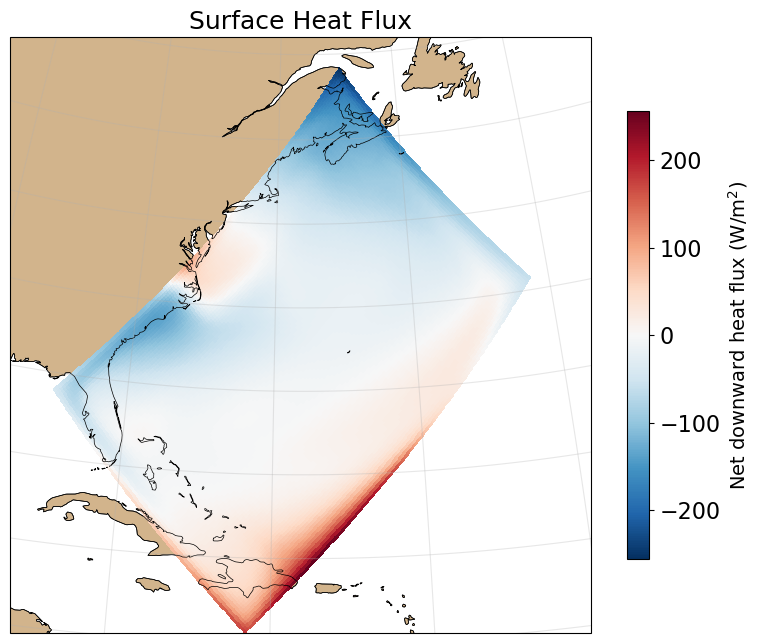

In [2]:
hflx = ds["sohefldo"].mean("time_counter").where(interior)

fig, ax = gyre_map(ds=ds)

vmax = float(abs(hflx).max())
pcm = ax.pcolormesh(
    ds.nav_lon.values, ds.nav_lat.values, hflx.values,
    shading="auto", cmap="RdBu_r",
    vmin=-vmax, vmax=vmax, transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="Net downward heat flux (W/m$^2$)", shrink=0.7)
ax.set_title("Surface Heat Flux")
fig.tight_layout()
fig.savefig("../figures/heat_flux.png", dpi=150, bbox_inches="tight")

## Surface heat flux — zonal mean

Zonally averaged heat flux as a function of latitude.

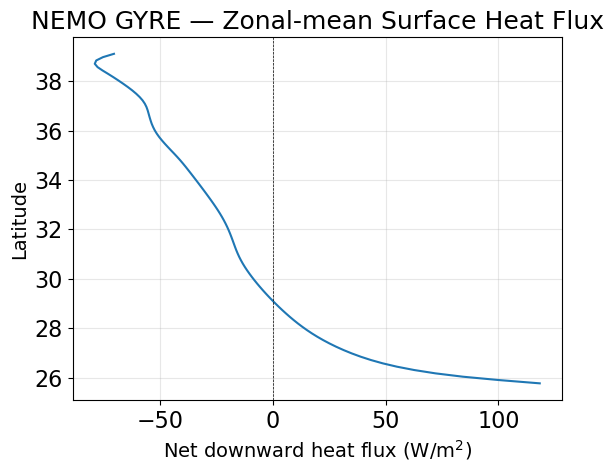

In [3]:
hflx_zonal = hflx.mean("x")
lat_1d = ds.nav_lat.isel(x=ds.sizes["x"] // 2)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(hflx_zonal.values, lat_1d.values)
ax.axvline(0, color="k", linewidth=0.5, linestyle="--")
ax.set_xlabel("Net downward heat flux (W/m$^2$)")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Zonal-mean Surface Heat Flux")
ax.grid(True, alpha=0.3)
fig.tight_layout()

## Total heat content time series

Volume-integrated ocean heat content: $H = \rho_0\, c_p \sum_{i,j,k}
T_{i,j,k}\, e1t_i\, e2t_j\, e3t_k\, \text{tmask}_{i,j,k}$

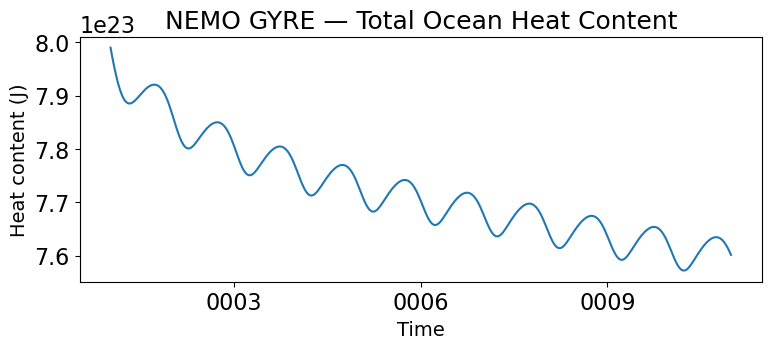

In [4]:
rho0 = 1026.0   # kg/m³
cp   = 3991.0    # J/(kg·K)

# Heat content: ρ₀ cₚ Σ T·dV  (vectorised over time)
hc = (rho0 * cp * (ds["votemper"] * cell_vol).sum([DEPTH, "y", "x"]))

fig, ax = plt.subplots(figsize=(8, 4))
hc.plot.line(ax=ax, x="time_counter")
ax.set_xlabel("Time")
ax.set_ylabel("Heat content (J)")
ax.set_title("NEMO GYRE — Total Ocean Heat Content")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
fig.tight_layout()

## Volume-mean salinity time series

Volume-weighted mean salinity over time.

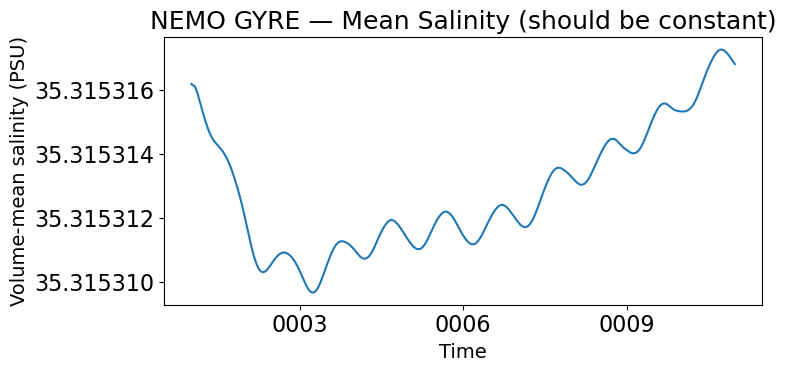

In [5]:
total_vol = cell_vol.sum()

# Volume-weighted mean salinity (vectorised over time)
sal_mean = (ds["vosaline"] * cell_vol).sum([DEPTH, "y", "x"]) / total_vol

fig, ax = plt.subplots(figsize=(8, 4))
sal_mean.plot.line(ax=ax, x="time_counter")
ax.set_xlabel("Time")
ax.set_ylabel("Volume-mean salinity (PSU)")
ax.set_title("NEMO GYRE — Mean Salinity (should be constant)")
ax.ticklabel_format(axis="y", useOffset=False)
fig.tight_layout()